<a href="https://colab.research.google.com/github/igedemadepradnyaairlangga/Dataanalitycs/blob/master/klasifikasi_gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyek Akhir : Klasifikasi Gambar**
- Nama: I Gede Made Pradnya Airlangga
- Email: pradnya.airlangga@gmail.com
- Id Dicoding: I Gede Made Pradnya Airlangga

**Menghubungkan dataset ke drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


In [ ]:
!ls

'0a3UtNzl5Ll3sq8K (1).png'	 hour.csv
 0a3UtNzl5Ll3sq8K.png		 kaggle.json
 0vugygEjxQJPr9yz.png		 Mall_Customers.csv
 amazon_prime_titles.csv	 rockpaperscissors
 best_model.h5			 rockpaperscissors.zip
 combined_dataset.csv		 rps-cv-images
 day.csv			'Salinan amazon_prime_titles.csv'
'e-shop clothing 2008.csv'	 udemy_output_All_Finance__Accounting_p1_p626.csv
'e-shop clothing 2008.csv.zip'


**libary**

In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from google.colab import files
from ipywidgets import FileUpload
import io
from PIL import Image

**path direktori ke dataset**

In [ ]:
# Path ke direktori dataset .zip di Google Drive
zip_dataset_path = '/content/gdrive/My Drive/Kaggle/rockpaperscissors.zip'
dataset_dir = '/content/gdrive/My Drive/Kaggle/rockpaperscissors'

In [ ]:
# Ekstrak dataset
if not os.path.exists(dataset_dir):
    with zipfile.ZipFile(zip_dataset_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)

**parameter dan inisiasi model**

In [17]:
# Parameter-model
input_shape = (150, 150, 3)
num_classes = 3

# Inisialisasi model sequential
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))  # Perbaikan: Menambahkan kurung tutup di sini
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


# Augmentasi data gambar
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3)  # Membagi dataset menjadi train dan validation

# Memuat dataset Anda ke dalam variabel X dan y
X = []
y = []

# Isi X dan y dengan data gambar dan label Anda

# Daftar kategori (misalnya: "paper", "rock", "scissors")
categories = ['scissors', 'rock', 'paper']

# Memuat data gambar dan label dari direktori dataset
for category in categories:
    category_path = os.path.join(dataset_dir, category)
    class_label = categories.index(category)  # Label kelas (misalnya, 0, 1, 2)

    for img_file in os.listdir(category_path):
        if img_file.endswith(".jpg") or img_file.endswith(".jpeg") or img_file.endswith(".png"):
            img_path = os.path.join(category_path, img_file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (150, 150))  # Sesuaikan dengan ukuran yang Anda inginkan
            X.append(img)
            y.append(class_label)

# Konversi ke array NumPy
X = np.array(X)
y = np.array(y)

# Mengubah label ke one-hot encoding
y = to_categorical(y, num_classes=3)

# Bagi dataset menjadi train set dan validation set (70% train, 30% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = train_datagen.flow(X_val, y_val, batch_size=32)

# Training model (maksimal 30 menit)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

epochs = 100  # Anda dapat menyesuaikan jumlah epoch sesuai kebutuhan
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(X_val) // 32,
    callbacks=[early_stopping, model_checkpoint])

# Memuat model terbaik
model.load_weights('best_model.h5')

# Widget "Choose File" untuk memilih file gambar

uploaded = files.upload()

if uploaded:
    # Pilih file gambar yang diunggah
    uploaded_image_path = list(uploaded.keys())[0]

    # Memproses gambar yang diunggah
    uploaded_image = Image.open(io.BytesIO(uploaded[uploaded_image_path]))
    uploaded_image = uploaded_image.resize((150, 150))
    uploaded_image = np.array(uploaded_image)
    uploaded_image = np.expand_dims(uploaded_image, axis=0)

    # Melakukan prediksi pada gambar yang diunggah
    prediction = model.predict(uploaded_image)
    labels = ['scissors', 'rock', 'paper']
    predicted_label = labels[np.argmax(prediction)]

    print("Hasil prediksi:", predicted_label)
else:
    print("Belum ada file yang diunggah.")


Epoch 1/100
42/42 [==============================] - 13s 274ms/step - loss: 1.0983 - accuracy: 0.3822 - val_loss: 1.0524 - val_accuracy: 0.3906
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


42/42 [==============================] - 14s 338ms/step - loss: 0.9577 - accuracy: 0.5034 - val_loss: 0.7616 - val_accuracy: 0.6701
Epoch 3/100
42/42 [==============================] - 14s 333ms/step - loss: 0.6792 - accuracy: 0.7081 - val_loss: 0.4666 - val_accuracy: 0.8455
Epoch 4/100
42/42 [==============================] - 14s 333ms/step - loss: 0.5197 - accuracy: 0.7818 - val_loss: 0.3892 - val_accuracy: 0.8750
Epoch 5/100
42/42 [==============================] - 14s 328ms/step - loss: 0.4535 - accuracy: 0.8269 - val_loss: 0.3102 - val_accuracy: 0.8889
Epoch 6/100
42/42 [==============================] - 11s 269ms/step - loss: 0.3649 - accuracy: 0.8578 - val_loss: 0.2921 - val_accuracy: 0.8872
Epoch 7/100
42/42 [==============================] - 11s 264ms/step - loss: 0.3588 - accuracy: 0.8518 - val_loss: 0.2897 - val_accuracy: 0.8802
Epoch 8/100
42/42 [==============================] - 10s 239ms/step - loss: 0.3615 - accuracy: 0.8698 - val_loss: 0.2451 - val_accuracy: 0.9167
Epoc

Saving 0P6uxM8Vr1DwySHe.png to 0P6uxM8Vr1DwySHe.png
1/1 [==============================] - 0s 76ms/step
Hasil prediksi: rock


**menampilkan hasil split dataset**

In [18]:
from sklearn.model_selection import train_test_split

# Bagi dataset menjadi train set dan validation set (70% train, 30% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

print("Jumlah data train set:", len(X_train))
print("Jumlah data validation set:", len(X_val))


Jumlah data train set: 1361
Jumlah data validation set: 584


**menampilkan hasil gambar prediksi**

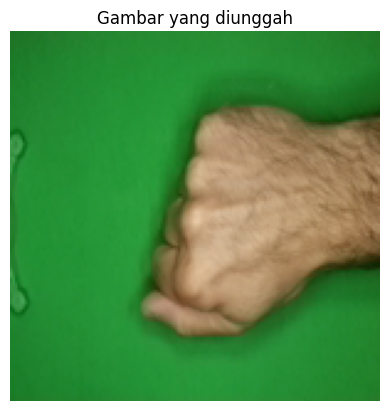

Hasil prediksi: rock


In [19]:
import matplotlib.pyplot as plt

# Visualisasi gambar yang diunggah
plt.imshow(uploaded_image[0])
plt.axis('off')
plt.title("Gambar yang diunggah")
plt.show()

# Hasil prediksi
labels = ['scissors', 'rock', 'paper']
predicted_label = labels[np.argmax(prediction)]
print("Hasil prediksi:", predicted_label)
